### Descrizione delle Scelte Progettuali per il Sistema di Deblurring delle Immagini

#### Architettura dei Modelli:

1. **Modello Residual Autoencoder**:
   - **Strati Conv2D**: Selezionati per la loro efficacia nel catturare relazioni spaziali e pattern nelle immagini, cruciali nel deblurring.
   - **Batch Normalization**: Implementati per normalizzare gli input dei layer successivi, migliorando la stabilità e l'efficienza dell'addestramento.
   - **MaxPooling e UpSampling**: Utilizzati per modulare la dimensionalità dei dati attraverso il network, permettendo al modello di apprendere rappresentazioni astratte.
   - **Connessioni Residue**: Essenziali per mantenere l'efficacia del flusso di gradiente e prevenire il vanishing gradient in una rete profonda.

2. **Miglioramenti del Modello**: 
   - **Incremento della Profondità**: Aggiungendo più layer convoluzionali, il modello può apprendere rappresentazioni più complesse, che sono essenziali per ricostruire accuratamente i dettagli sottili nelle immagini sfocate.
   - **Dense Layer nel Bottleneck**: Questa scelta permette di comprimere l'informazione in una rappresentazione più densa, che può catturare aspetti astratti e complessi delle immagini.
   - **Skip Connections**: Aiutano a preservare i dettagli spaziali durante il processo di deblurring, fondamentali per garantire che le immagini ricostruite mantengano la fedeltà rispetto agli originali.

#### Addestramento e Ottimizzazione:

1. **Ottimizzatori**:
   - **Adam**: Scelto per la sua efficienza nell'inizio dell'addestramento, ottimizza rapidamente grazie alla sua capacità di regolare automaticamente il tasso di apprendimento.
   - **SGD**: Utilizzato nella fase successiva per affinare i risultati. La sua convergenza più lenta e meticolosa è ideale per affinamenti finali, migliorando la precisione del modello.

2. **Scelta del Batch Size**:
   - Il batch size è stato impostato a 32. Questa dimensione è un compromesso efficace tra memoria richiesta e velocità di addestramento. 

3. **Gestione degli Step di Addestramento**:
   - Per assicurare che ogni immagine nel dataset sia vista dal modello, sono stati configurati step sufficienti per coprire tutte le 60.000 immagini del dataset MNIST in ogni epoca. Ciò garantisce che l'intero dataset contribuisca all'addestramento in ogni ciclo, permettendo al modello di apprendere in modo più uniforme e completo.

4. **Early Stopping**: 
   - Questa tecnica è stata implementata per evitare l'overfitting, ma nel mio ultimo caso non è stata necessaria. Questo suggerisce che il modello ha continuato a imparare efficacemente per tutta la durata dell'addestramento.

#### Valutazione e Analisi:

1. **Curva di Apprendimento**:
   - L'analisi delle curve di apprendimento fornisce indicazioni utili sull'efficacia dell'addestramento e sulla presenza di eventuali problemi come overfitting o underfitting. 

2. **Visualizzazione delle Attivazioni**:
   - Esaminare le attivazioni dei vari layer consente di comprendere quali tipi di caratteristiche il modello sta effettivamente imparando, offrendo un'intuizione preziosa sul suo funzionamento interno.

3. **Confronto tra Immagini**:
   - La valutazione qualitativa attraverso il confronto diretto tra immagini originali, sfocate e de-sfocate permette di valutare visivamente l'efficacia del deblurring.

In [37]:
from tensorflow.keras import layers, models, optimizers, Input, callbacks, datasets
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [38]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)
x_val, x_test = train_test_split(x_test, test_size=0.5)
batchsize=32

In [39]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)



In [41]:
def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

32


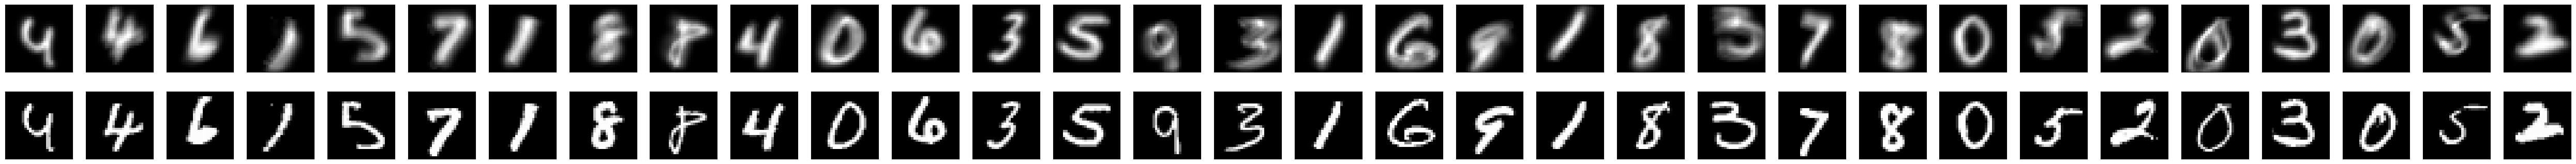

In [42]:
blurred_gen = generator(x_train, batchsize=32)
blurred_images, clear_images = next(blurred_gen)
plot(blurred_images, clear_images)

In [43]:
def residual_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Strato encoder
    # Applico due layer convoluzionali con normalizzazione batch e max pooling per ridurre le dimensioni
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bottleneck con connessioni residue
    # Utilizzo un ciclo per aggiungere ripetutamente layer convoluzionali che rendono la rete più profonda
    for _ in range(3):
        identity = x
        # Applico un blocco convoluzionale con normalizzazione batch
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)

        # Aggiusto l'identità per allinearla in termini di dimensioni
        identity_adjusted = layers.Conv2D(64, (1, 1))(identity)
        # Aggiungo la connessione residua
        x = layers.add([x, identity_adjusted])

    # Strato decoder
    # Aumento la dimensione delle immagini e applico i layer convoluzionali trasposti per ricostruire l'immagine originale
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = models.Model(input_img, decoded)

    return model

model =residual_autoencoder((28, 28, 1))
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_46 (Conv2D)          (None, 28, 28, 64)           640       ['input_8[0][0]']             
                                                                                                  
 batch_normalization_38 (Ba  (None, 28, 28, 64)           256       ['conv2d_46[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_47 (Conv2D)          (None, 28, 28, 64)           36928     ['batch_normalization_38

In [49]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

blurred_gen = generator(x_train, batchsize)
validation_gen = generator(x_val, batchsize)
epoch=len(x_train)//batchsize
# Training con Adam e Early Stopping
model.compile(optimizer='adam', loss='mean_squared_error')
history_adam=model.fit(blurred_gen, epochs=20, steps_per_epoch=epoch, validation_data=validation_gen, validation_steps=200, callbacks=[early_stopping])

blurred_gen = generator(x_train, batchsize)
validation_gen = generator(x_val, batchsize)

# Training con SGD per affinamento
sgd_optimizer = optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=sgd_optimizer, loss='mean_squared_error')
history_sgd=model.fit(blurred_gen, epochs=30, steps_per_epoch=epoch, validation_data=validation_gen, validation_steps=200, callbacks=[early_stopping])

Epoch 1/20
1875/1875 [==============================] - 204s 108ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 2/20
1875/1875 [==============================] - 195s 104ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 3/20
1875/1875 [==============================] - 187s 100ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 4/20
1875/1875 [==============================] - 188s 101ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/20
1875/1875 [==============================] - 188s 100ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 6/20
1875/1875 [==============================] - 192s 102ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 7/20
1875/1875 [==============================] - 189s 101ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/20
1875/1875 [==============================] - 188s 100ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 9/20
1875/1875 [==============================] - 186s 99ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 10/20
1875/1875 [========================

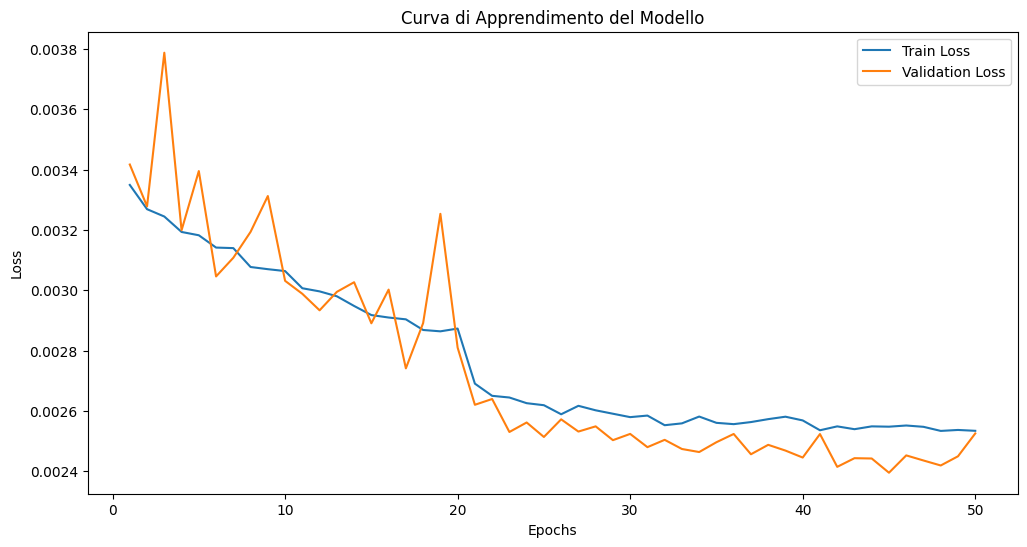

In [51]:
# Dati di loss e validation loss di entrambe le fasi uniti (primi 20 adam, poi SGD)
total_train_loss = history_adam.history['loss'] + history_sgd.history['loss']
total_val_loss = history_adam.history['val_loss'] + history_sgd.history['val_loss']

# Calcolo i numeri delle epoche
epochs = range(1, len(total_train_loss) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, total_train_loss, label='Train Loss')
plt.plot(epochs, total_val_loss, label='Validation Loss')
plt.title('Curva di Apprendimento del Modello')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 133ms/step


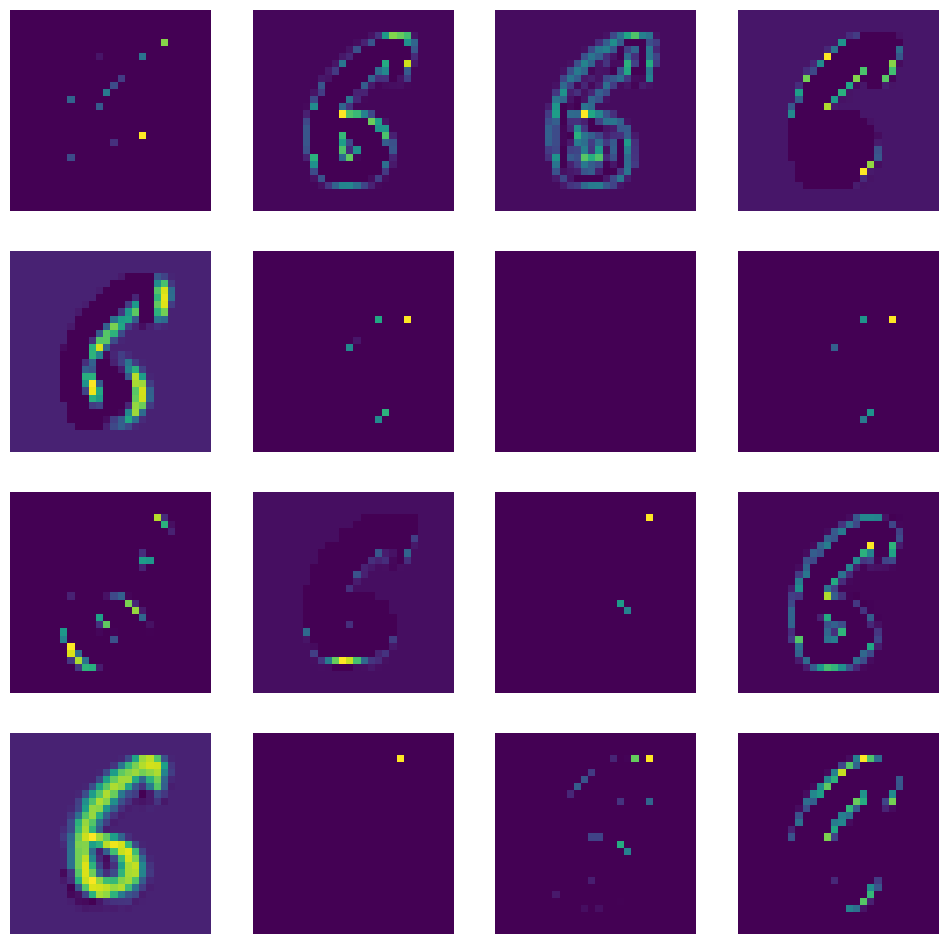

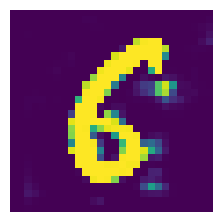

In [52]:
# Analisi delle Attivazioni
input_image = x_test[np.random.choice(range(len(x_test)))]
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]

selected_layers = [layer_outputs[0], layer_outputs[-1]]
activation_model = models.Model(inputs=model.input, outputs=selected_layers)

input_image = np.expand_dims(input_image, axis=0)
activations = activation_model.predict(input_image)

max_maps = 16

for layer_activation in activations:
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_features = min(n_features, max_maps)

    n_cols = 4
    n_rows = np.ceil(n_features / n_cols).astype(int)

    plt.figure(figsize=(12, 12))
    for i in range(n_features):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()


1/1 [==============================] - 0s 149ms/step


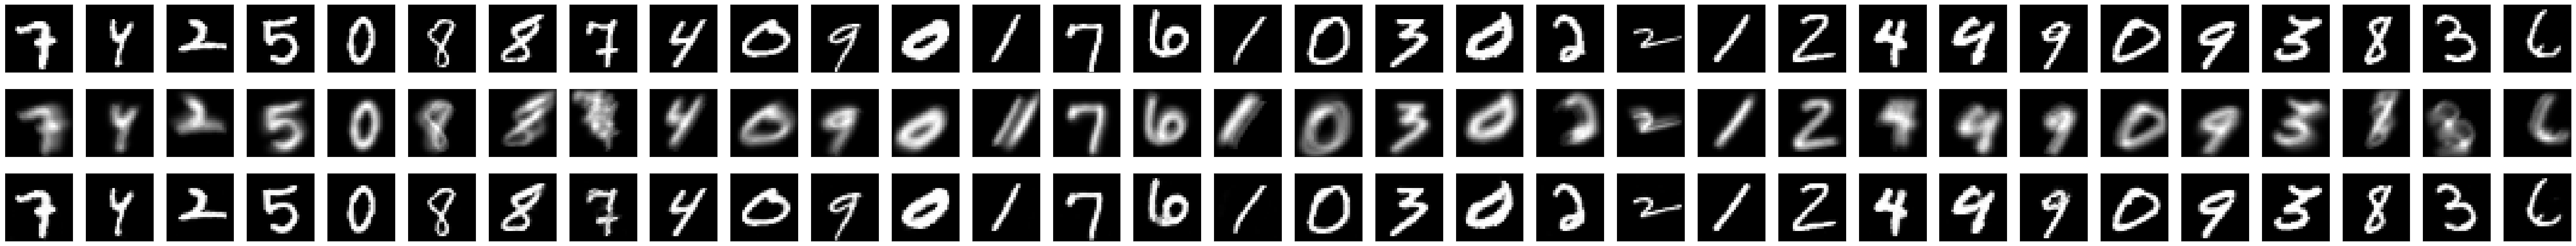

In [53]:
#Confronto tra immagini originali, blurrate e deblurrate
def plot_comparison(original, blurred, deblurred):
    n = original.shape[0]
    plt.figure(figsize=(2*n, 6))

    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(blurred[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(deblurred[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

blurred_gen = generator(x_train, batchsize)

blurred_images, clear_images = next(blurred_gen)
deblurred_images = model.predict(blurred_images)
deblurred_images = np.clip(deblurred_images, 0, 1)

plot_comparison(clear_images, blurred_images, deblurred_images)



In [54]:
# Valutazione del modello
test_gen = generator(x_test, batchsize=10000)
mse_scores = []

for _ in range(10):
    test_blurred_images, test_clear_images = next(test_gen)
    mse = model.evaluate(test_blurred_images, test_clear_images, verbose=0)
    mse_scores.append(mse)

mse_media = np.mean(mse_scores)
mse_dev_std = np.std(mse_scores)

print("MSE media:", mse_media)
print("Deviazione standard MSE:", mse_dev_std)

MSE media: 0.002428945549763739
Deviazione standard MSE: 2.9707685035606706e-05
